In [4]:
!pip install duckduckgo-search
!pip install tensorflow

In [6]:
from duckduckgo_search import DDGS
import requests
import os
from tqdm import tqdm

def download_images(query, folder, max_images=100):
    os.makedirs(folder, exist_ok=True)
    count = 0
    with DDGS() as ddgs:
        results = ddgs.images(query, max_results=max_images)
        for result in tqdm(results, desc=f"Downloading {query}"):
            try:
                img_data = requests.get(result["image"], timeout=5).content
                with open(os.path.join(folder, f"{query.replace(' ', '_')}_{count}.jpg"), 'wb') as f:
                    f.write(img_data)
                count += 1
            except:
                continue


fruits = ["grape cluster", "grapefruit", "apple fruit", "banana fruit", "mango fruit", "orange fruit"]

# Download for each fruit
for fruit in fruits:
    download_images(fruit, folder=f"dataset/{fruit.split()[0]}", max_images=1000)




In [7]:
from PIL import Image
import os

dataset_dir = '/content/dataset'

for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        filepath = os.path.join(root, file)
        try:
            img = Image.open(filepath)
            img.verify()  # verify loads the image to check for corruption
        except (IOError, SyntaxError) as e:
            print(f"Bad image file: {filepath}, removing.")
            # Uncomment to delete corrupted files:
            os.remove(filepath)


Bad image file: /content/dataset/apple/apple_fruit_147.jpg, removing.
Bad image file: /content/dataset/apple/apple_fruit_145.jpg, removing.
Bad image file: /content/dataset/apple/apple_fruit_189.jpg, removing.
Bad image file: /content/dataset/apple/apple_fruit_161.jpg, removing.
Bad image file: /content/dataset/apple/apple_fruit_93.jpg, removing.
Bad image file: /content/dataset/apple/apple_fruit_148.jpg, removing.
Bad image file: /content/dataset/apple/apple_fruit_137.jpg, removing.
Bad image file: /content/dataset/apple/apple_fruit_33.jpg, removing.
Bad image file: /content/dataset/apple/apple_fruit_279.jpg, removing.
Bad image file: /content/dataset/apple/apple_fruit_140.jpg, removing.
Bad image file: /content/dataset/apple/apple_fruit_97.jpg, removing.
Bad image file: /content/dataset/apple/apple_fruit_259.jpg, removing.
Bad image file: /content/dataset/apple/apple_fruit_129.jpg, removing.
Bad image file: /content/dataset/apple/apple_fruit_63.jpg, removing.
Bad image file: /content

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import os

# Path to your dataset folder
dataset_dir = '/content/dataset'

# Parameters
img_height, img_width = 150, 150  # common size for CNN input
batch_size = 32
num_classes = 6

# Create an ImageDataGenerator with rescaling and basic augmentation (optional)
train_datagen = ImageDataGenerator(
    rescale=1./255,           # normalize pixel values 8 bit per channel image = 255
    validation_split=0.2,     # 20% for validation
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train data generator
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class CNNModel(tf.keras.Model):
    def __init__(self, num_classes, **kwargs):
        super(CNNModel, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.conv1 = layers.Conv2D(32, (3,3), activation='relu')
        self.pool1 = layers.MaxPooling2D(2, 2)
        self.conv2 = layers.Conv2D(64, (3,3), activation='relu')
        self.pool2 = layers.MaxPooling2D(2, 2)
        self.conv3 = layers.Conv2D(128, (3,3), activation='relu')
        self.pool3 = layers.MaxPooling2D(2, 2)
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dropout = layers.Dropout(0.5)
        self.out = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        if training:
            x = self.dropout(x, training=training)
        return self.out(x)

    def get_config(self):
        config = super(CNNModel, self).get_config()
        config.update({'num_classes': self.num_classes})
        return config

    @classmethod
    def from_config(cls, config):
        if 'num_classes' not in config:
            config['num_classes'] = 6
        return cls(**config)

model = CNNModel(num_classes)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

# Save the model for later use
model.save('/content/models/fruit_classifier_CNN_model.h5')


Found 1456 images belonging to 6 classes.
Found 361 images belonging to 6 classes.
Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.2354 - loss: 1.9447 - val_accuracy: 0.4183 - val_loss: 1.4561
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.3817 - loss: 1.5078 - val_accuracy: 0.6039 - val_loss: 1.1605
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.4802 - loss: 1.3932 - val_accuracy: 0.5900 - val_loss: 1.1087
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.5130 - loss: 1.3227 - val_accuracy: 0.5983 - val_loss: 1.0630
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.5383 - loss: 1.2310 - val_accuracy: 0.6731 - val_loss: 0.9959
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.5516 - loss: 1.2029 - val_accuracy: 0.6177 - val_loss: 0.9820
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.5447 - loss: 1.2026 - val_accuracy: 0.7064 - val_loss: 0.9386
Epoch 8/15
46/46 ━━━━━━━━━━━

In [10]:
class MLPModel(tf.keras.Model):
    def __init__(self, num_classes, img_height, img_width, **kwargs):
        super(MLPModel, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.img_height = img_height
        self.img_width = img_width

        self.flatten = layers.Flatten(input_shape=(img_height, img_width, 3))
        self.dense1 = layers.Dense(512, activation='relu')
        self.dense2 = layers.Dense(256, activation='relu')
        self.out = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.out(x)

    def get_config(self):
        config = super(MLPModel, self).get_config()
        config.update({
            'num_classes': self.num_classes,
            'img_height': self.img_height,
            'img_width': self.img_width,
        })
        return config

    @classmethod
    def from_config(cls, config):
        # fallback defaults (if loading older models)
        config.setdefault('num_classes', 6)
        config.setdefault('img_height', 150)
        config.setdefault('img_width', 150)
        return cls(**config)


model2 = MLPModel(num_classes, img_height, img_width)
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history2 = model2.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

# Save the model for later use
model2.save('/content/models/fruit_classifier_MLP_model.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.1913 - loss: 50.3144 - val_accuracy: 0.2659 - val_loss: 6.8578
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.2456 - loss: 6.7493 - val_accuracy: 0.2770 - val_loss: 2.6515
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.2612 - loss: 4.3385 - val_accuracy: 0.2964 - val_loss: 2.7463
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.3040 - loss: 2.6965 - val_accuracy: 0.2798 - val_loss: 3.5000
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.2799 - loss: 2.9860 - val_accuracy: 0.3352 - val_loss: 1.8534
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.3304 - loss: 2.0337 - val_accuracy: 0.3269 - val_loss: 1.8129
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.3610 - loss: 2.0305 - val_accuracy: 0.3850 - val_loss: 1.6115
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.3994 - loss: 1.6367 - val_accuracy: 0.3352 - val_loss

In [15]:
class LSTMModel(tf.keras.Model):
    def __init__(self, num_classes, img_height, img_width, **kwargs):
        super(LSTMModel, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.img_height = img_height
        self.img_width = img_width

        # LSTM with default activation ('tanh') to prevent exploding gradients
        self.lstm = layers.LSTM(128)

        # Final dense softmax output
        self.out = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        # Ensure the input is reshaped correctly for LSTM: (batch_size, time_steps, features)
        x = tf.reshape(inputs, [tf.shape(inputs)[0], self.img_height, self.img_width * 3])
        x = self.lstm(x)
        return self.out(x)

    def get_config(self):
        config = super(LSTMModel, self).get_config()
        config.update({
            'num_classes': self.num_classes,
            'img_height': self.img_height,
            'img_width': self.img_width,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


model3 = LSTMModel(num_classes, img_height, img_width)
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history3 = model3.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

# Save the model for later use
model3.save('/content/models/fruit_classifier_LSTM_model.h5')

Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.2262 - loss: 1.8493 - val_accuracy: 0.2410 - val_loss: 1.7444
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.2322 - loss: 1.7566 - val_accuracy: 0.2881 - val_loss: 1.7423
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.2759 - loss: 1.7335 - val_accuracy: 0.2909 - val_loss: 1.7195
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.2504 - loss: 1.7304 - val_accuracy: 0.2438 - val_loss: 1.7171
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.2549 - loss: 1.7373 - val_accuracy: 0.2798 - val_loss: 1.7237
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.2885 - loss: 1.7051 - val_accuracy: 0.2632 - val_loss: 1.7264
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.2891 - loss: 1.6992 - val_accuracy: 0.2881 - val_loss: 1.7225
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.2907 - loss: 1.7040 - val_accuracy: 0.3019 - val_loss:

In [12]:
class AutoencoderClassifier(tf.keras.Model):
    def __init__(self, num_classes, **kwargs):
        super(AutoencoderClassifier, self).__init__(**kwargs)
        self.num_classes = num_classes

        # Encoder
        self.encoder_conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.encoder_pool1 = layers.MaxPooling2D((2, 2), padding='same')
        self.encoder_conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.encoder_pool2 = layers.MaxPooling2D((2, 2), padding='same')

        # Flatten and classifier
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dropout = layers.Dropout(0.5)
        self.out = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.encoder_conv1(inputs)
        x = self.encoder_pool1(x)
        x = self.encoder_conv2(x)
        x = self.encoder_pool2(x)

        x = self.flatten(x)
        x = self.dense1(x)
        if training:
            x = self.dropout(x, training=training)
        return self.out(x)

    def get_config(self):
        config = super(AutoencoderClassifier, self).get_config()
        config.update({'num_classes': self.num_classes})
        return config

    @classmethod
    def from_config(cls, config):
        config.setdefault('num_classes', 6)  # Fallback default
        return cls(**config)

model4 = AutoencoderClassifier(num_classes)
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history4 = model4.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

# Save the model for later use
model4.save('/content/models/fruit_classifier_AutoEncoder_Classifier_model.h5')

Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.1941 - loss: 2.4330 - val_accuracy: 0.3740 - val_loss: 1.5107
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.3409 - loss: 1.6046 - val_accuracy: 0.4654 - val_loss: 1.3739
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.4498 - loss: 1.4690 - val_accuracy: 0.5762 - val_loss: 1.2203
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.5099 - loss: 1.3160 - val_accuracy: 0.6094 - val_loss: 1.1337
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.5515 - loss: 1.2540 - val_accuracy: 0.6371 - val_loss: 1.0670
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.5552 - loss: 1.2018 - val_accuracy: 0.6260 - val_loss: 1.0375
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.5580 - loss: 1.1741 - val_accuracy: 0.6371 - val_loss: 1.0380
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.5910 - loss: 1.0963 - val_accuracy: 0.6454 - v

In [13]:
class VisionTransformer(tf.keras.Model):
    def __init__(self, num_classes, image_size=150, patch_size=10,
                 projection_dim=64, num_heads=4, transformer_layers=4,
                 transformer_units=[128, 64], mlp_head_units=[128], **kwargs):
        super(VisionTransformer, self).__init__(**kwargs)

        # Store config for serialization
        self.num_classes = num_classes
        self.image_size = image_size
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.transformer_layers = transformer_layers
        self.transformer_units = transformer_units
        self.mlp_head_units = mlp_head_units

        self.num_patches = (image_size // patch_size) ** 2

        # Patch extraction and encoding
        self.patch_layer = layers.Lambda(self._extract_patches)
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(input_dim=self.num_patches, output_dim=projection_dim)

        # Transformer encoder blocks
        self.encoder_layers = []
        for _ in range(transformer_layers):
            self.encoder_layers.append({
                "norm1": layers.LayerNormalization(epsilon=1e-6),
                "mha": layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1),
                "dropout1": layers.Dropout(0.1),
                "norm2": layers.LayerNormalization(epsilon=1e-6),
                "mlp_dense1": layers.Dense(transformer_units[0], activation="gelu"),
                "mlp_dense2": layers.Dense(transformer_units[1], activation="gelu"),
                "dropout2": layers.Dropout(0.1)
            })

        # Classification head
        self.norm = layers.LayerNormalization(epsilon=1e-6)
        self.pool = layers.GlobalAveragePooling1D()
        self.mlp_head = []
        for units in mlp_head_units:
            self.mlp_head.append(layers.Dense(units, activation='relu'))
            self.mlp_head.append(layers.Dropout(0.5))
        self.out = layers.Dense(num_classes, activation='softmax')

    def _extract_patches(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dim = patches.shape[-1]
        return tf.reshape(patches, [batch_size, -1, patch_dim])

    def call(self, inputs, training=False):
        x = self.patch_layer(inputs)
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embed = self.position_embedding(positions)
        x = self.projection(x) + pos_embed

        for layer in self.encoder_layers:
            x1 = layer["norm1"](x)
            attn_output = layer["mha"](x1, x1)
            attn_output = layer["dropout1"](attn_output, training=training)
            x = x + attn_output

            x2 = layer["norm2"](x)
            x2 = layer["mlp_dense1"](x2)
            x2 = layer["mlp_dense2"](x2)
            x2 = layer["dropout2"](x2, training=training)
            x = x + x2

        x = self.norm(x)
        x = self.pool(x)
        for layer in self.mlp_head:
            x = layer(x, training=training) if isinstance(layer, layers.Dropout) else layer(x)
        return self.out(x)

    def get_config(self):
        config = super(VisionTransformer, self).get_config()
        config.update({
            "num_classes": self.num_classes,
            "image_size": self.image_size,
            "patch_size": self.patch_size,
            "projection_dim": self.projection_dim,
            "num_heads": self.num_heads,
            "transformer_layers": self.transformer_layers,
            "transformer_units": self.transformer_units,
            "mlp_head_units": self.mlp_head_units,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

model5 = VisionTransformer(num_classes=num_classes)

model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 15
history5 = model5.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

model5.save('/content/models/fruit_classifier_ViT_model.h5')


Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.1930 - loss: 1.9552 - val_accuracy: 0.2936 - val_loss: 1.7513
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.2232 - loss: 1.7847 - val_accuracy: 0.3850 - val_loss: 1.5631
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.3630 - loss: 1.6166 - val_accuracy: 0.5374 - val_loss: 1.3641
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.4260 - loss: 1.5457 - val_accuracy: 0.5374 - val_loss: 1.2782
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.4310 - loss: 1.4933 - val_accuracy: 0.6066 - val_loss: 1.1837
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.4953 - loss: 1.3591 - val_accuracy: 0.5928 - val_loss: 1.2134
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.4898 - loss: 1.3734 - val_accuracy: 0.5983 - val_loss: 1.1433
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.5553 - loss: 1.2873 - val_accuracy: 0.6648 - v


Evaluating model: CNNModel


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
              precision    recall  f1-score   support

       apple       0.68      0.56      0.61        54
      banana       0.69      0.60      0.64        60
       grape       0.57      0.85      0.68        65
  grapefruit       0.83      0.68      0.75        74
       mango       0.46      0.39      0.42        49
      orange       0.70      0.80      0.75        59

    accuracy                           0.66       361
   macro avg       0.66      0.64      0.64       361
weighted avg       0.67      0.66      0.65       361



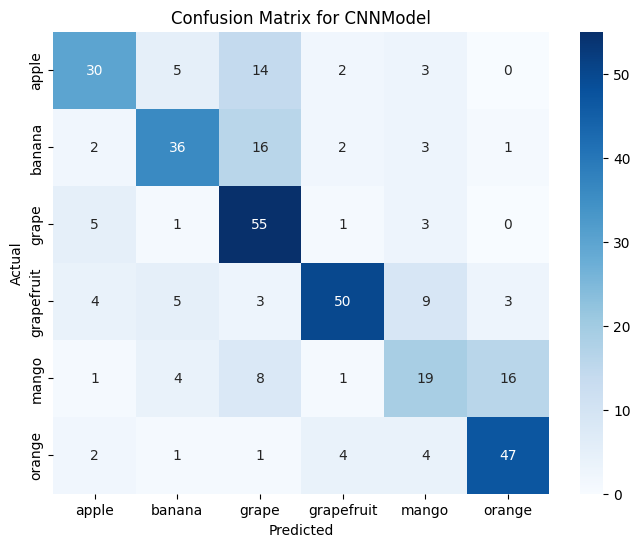


Evaluating model: MLPModel


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 967ms/step
              precision    recall  f1-score   support

       apple       0.40      0.39      0.39        54
      banana       0.46      0.27      0.34        60
       grape       0.63      0.63      0.63        65
  grapefruit       0.36      0.61      0.45        74
       mango       0.28      0.31      0.29        49
      orange       0.53      0.27      0.36        59

    accuracy                           0.43       361
   macro avg       0.44      0.41      0.41       361
weighted avg       0.45      0.43      0.42       361



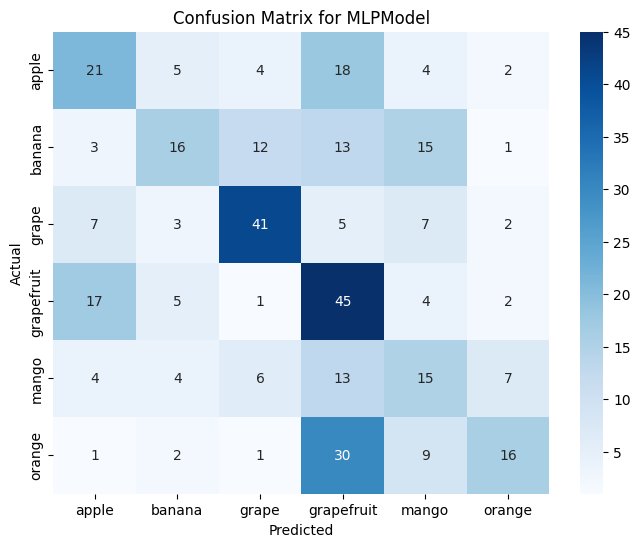


Evaluating model: LSTMModel


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step   
              precision    recall  f1-score   support

       apple       0.25      0.04      0.06        54
      banana       0.33      0.02      0.03        60
       grape       0.48      0.46      0.47        65
  grapefruit       0.28      0.81      0.42        74
       mango       0.15      0.08      0.11        49
      orange       0.31      0.27      0.29        59

    accuracy                           0.31       361
   macro avg       0.30      0.28      0.23       361
weighted avg       0.31      0.31      0.25       361



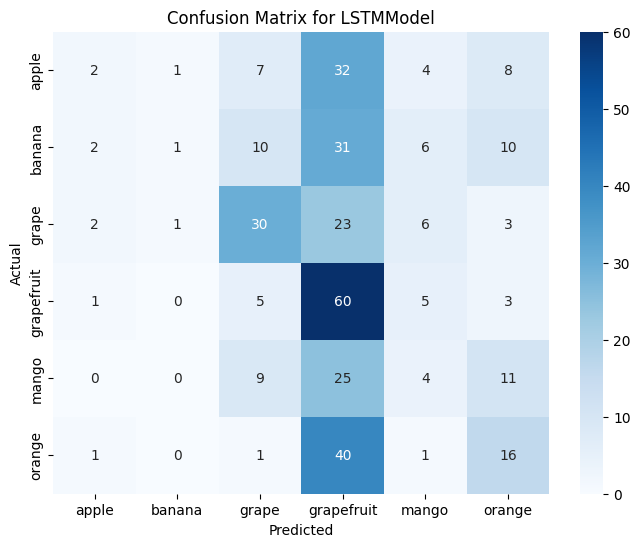


Evaluating model: AutoencoderClassifier


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
              precision    recall  f1-score   support

       apple       0.69      0.65      0.67        54
      banana       0.68      0.60      0.64        60
       grape       0.71      0.85      0.77        65
  grapefruit       0.94      0.65      0.77        74
       mango       0.52      0.67      0.58        49
      orange       0.73      0.80      0.76        59

    accuracy                           0.70       361
   macro avg       0.71      0.70      0.70       361
weighted avg       0.73      0.70      0.71       361



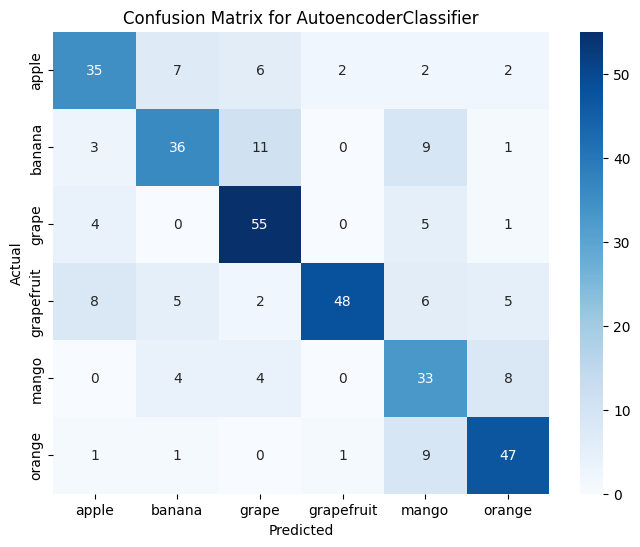


Evaluating model: VisionTransformer


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
              precision    recall  f1-score   support

       apple       0.69      0.54      0.60        54
      banana       0.71      0.58      0.64        60
       grape       0.57      0.86      0.68        65
  grapefruit       0.78      0.69      0.73        74
       mango       0.41      0.33      0.36        49
      orange       0.69      0.78      0.73        59

    accuracy                           0.65       361
   macro avg       0.64      0.63      0.63       361
weighted avg       0.65      0.65      0.64       361



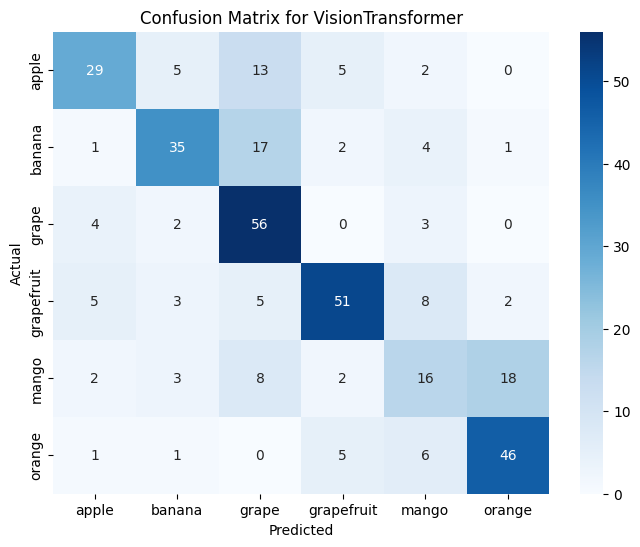

In [19]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Preloaded models
models = [model, model2, model3, model4, model5]
model_names = ['CNNModel','MLPModel','LSTMModel', 'AutoencoderClassifier', 'VisionTransformer']

# Evaluate each model
for model, model_name in zip(models, model_names):
    print(f"\nEvaluating model: {model_name}")

    # Predict on validation data
    validation_generator.reset()
    preds = model.predict(validation_generator, verbose=1)
    y_pred = np.argmax(preds, axis=1)
    y_true = validation_generator.classes

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=list(validation_generator.class_indices.keys())))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=list(validation_generator.class_indices.keys()),
                yticklabels=list(validation_generator.class_indices.keys()),
                cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
